In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from scipy.optimize import minimize
from scipy.optimize import differential_evolution
import matplotlib.pyplot as plt

In [2]:
# 한글 폰트 사용 위해 세팅
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/gulim.ttc"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

In [3]:
#interest_rate = pd.read_csv("./대출금리.csv" )
#buy_index = pd.read_csv("./아파트매매가격지수.csv")
#year_index = pd.read_csv("./아파트전세가격지수.csv")
#seoul_gu = pd.read_csv("./서울시 구.csv")
#buy_year_rate = pd.read_csv("./아파트 매매가격대비 전세가격비율.csv")

interest_rate = pd.read_csv("./대출금리200212.csv" )
seoul_gu = pd.read_csv("./서울시 구.csv")
buy_index = pd.read_csv("./월간 아파트 매매가격지수_20240129.csv")
year_index = pd.read_csv("./월간 아파트 전세가격지수_20240129.csv")
buy_year_rate = pd.read_csv("./아파트 매매가격대비 전세가격비율_20240129.csv")
seoul_buy_year_rate = pd.read_csv("./아파트 서울 매매가격대비 전세가격비율_20240129.csv")
seoul_buy_index = pd.read_csv("./월간 서울 아파트 매매가격지수_20240129.csv")
seoul_year_index = pd.read_csv("./월간 서울 아파트 전세가격지수_20240129.csv")

# 1. 전처리

### 1. 주택금리 전처리

##### 1.1) 주택담보대출 (연리%)만 가져오기

In [4]:
interest_rate2 = interest_rate[interest_rate['계정항목별'] == interest_rate['계정항목별'][10]].transpose().reset_index(drop=False).iloc[1:]
interest_rate2.columns = ['날짜', '주택담보대출 (연리%)']

1.2) 날짜 형식 통일

In [5]:
interest_rate2['날짜'] = pd.to_datetime(interest_rate2['날짜'])

In [6]:
interest_rate3 = interest_rate2.set_index('날짜')
interest_rate3 = interest_rate3.applymap(lambda x: pd.to_numeric(x, errors='coerce')) #수치형 변환 추가

In [7]:
interest_rate3 = interest_rate3.iloc[1:] #2003-01-01	~ 2023-11-01

## 전처리 함수

In [8]:
def region(df) :
  #전국, 광역시 단위 가져오기
  temp = df[df['지역명'].str.contains('전국|서울|강북14개구|강남11개구|6개광역시|부산|대전|대구|인천|광주|울산')].transpose().reset_index(drop=False).iloc[1:]
  temp.columns = ['날짜','전국','서울', '강북14개구', '강남11개구', '6개광역시', '부산', '대전', '대구', '인천', '광주', '울산']

  #날짜 형식 통일
  temp['날짜'] = [datetime.strptime(date, "%b-%y") for date in temp['날짜']]
  temp2 = temp.set_index('날짜')
  temp3 = temp2.applymap(lambda x: pd.to_numeric(x, errors='coerce')) #수치형 변환 추가

  ##2003-01-01	~ 2023-11-01까지만 가져오기
  temp4 = temp3.loc['2003-01-01':'2023-11-01']

  return(temp4)

In [9]:
bin = ['날짜']
gu_list = seoul_buy_index.transpose().iloc[0].to_list()

def seoul(df) :
  #서울시만 가져오기
  temp = df.transpose().reset_index().iloc[1:]
  temp.columns = bin + gu_list

  #날짜 형식 통일
  try:
    temp2 = temp.set_index('날짜')['03-Jan':'23-Nov']
  except KeyError:
    temp2 = temp.set_index('날짜')['Jan-03':'Nov-23']
  temp2.index = region_buy.index
  temp3 = temp2.applymap(lambda x: pd.to_numeric(x, errors='coerce'))

  return(temp3)

### 2. 아파트 매매가격지수 전처리

In [10]:
#아파트 매매가격지수
region_buy = region(buy_index) # 전국
seoul_buy = seoul(seoul_buy_index) # 서울

### 3. 아파트 전세가격지수 전처리

In [11]:
#아파트 전세가격지수
region_year_index = region(year_index) # 전국
seoul_year_index = seoul(seoul_year_index) # 서울

### 4. 전세/매매가격 지수 비율 전처리

In [12]:
#아파트 전세가격지수
region_buy_year_rate = region(buy_year_rate) # 전국
seoul_buy_year_rate = seoul(seoul_buy_year_rate) # 서울

### 5. 결측치 처리 (선형보간법)

In [13]:
Gangbook = ['종로구','중구','용산구', '성동구', '광진구', '동대문구', '중랑구',	'성북구',	'강북구'	,'도봉구',	'노원구',	'은평구',	'서대문구',	'마포구']
Gangnam = ['양천구'	,'강서구',	'구로구',	'금천구',	'영등포구',	'동작구',	'관악구',	'서초구'	,'강남구',	'송파구',	'강동구']

# 보간 수행
seoul_buy_year_rate_in = seoul_buy_year_rate.interpolate(method='linear', limit_direction='both')

# 강남, 강북, 서울 전체의 평균 계산
seoul_buy_year_rate_in['강남평균'] = seoul_buy_year_rate_in[Gangnam].mean(axis=1)
seoul_buy_year_rate_in['강북평균'] = seoul_buy_year_rate_in[Gangbook].mean(axis=1)
seoul_buy_year_rate_in['서울평균'] = seoul_buy_year_rate_in.mean(axis=1)

# 실제 평균과의 차이 계산
diff_gangnam = region_buy_year_rate['강남11개구'] - seoul_buy_year_rate_in['강남평균']
diff_gangbuk = region_buy_year_rate['강북14개구'] - seoul_buy_year_rate_in['강북평균']
diff_seoul = region_buy_year_rate['서울'] - seoul_buy_year_rate_in['서울평균']

# 각 구별 차이를 반영하여 실제 평균과 일치하도록 조정
for 구 in Gangnam:
    seoul_buy_year_rate_in[구] += diff_gangnam

for 구 in Gangbook:
    seoul_buy_year_rate_in[구] += diff_gangbuk

# 서울 전체 평균에 맞추어 조정
seoul_buy_year_rate_in.update(region_buy_year_rate['서울'], overwrite=False)
seoul_buy_year_rate_in = seoul_buy_year_rate_in.drop(columns =['강남평균', '강북평균', '서울평균'], axis = 1)
seoul_buy_year_rate = seoul_buy_year_rate_in

### 6. 임대료 데이터 만들기
(전세 지수 : year_index)* (전세/매매가격 지수 : year_buy_rate ) * (주택담보대출금리(%) : interest_rate / 1200 + 1)

In [14]:
def rent(df, year_index) :
  #1) (전세/매매가격 지수)/100 * (주택담보대출금리(%) / 1200 + 1)
  columns = df.columns
  df2 = df.reset_index()
  for i in columns  :
    df2[i] = df2[i]/100 * (interest_rate3.reset_index()['주택담보대출 (연리%)'] /100+ 1)

  #2) (전세 지수) * 위 블록 결과(year_buy_rate4)
  df2 = df2.set_index('날짜') # (전세/매매가격 지수) * (주택담보대출금리(%) / 12 /100+1)

  rent = year_index * df2/12
  return(rent)

In [15]:
seoul_rent = rent(seoul_buy_year_rate, seoul_year_index)
region_rent = rent(region_buy_year_rate, region_year_index)

In [16]:
# Initialize dictionaries to store the data frames
buy_data_frames = {}
rent_data_frames = {}

# Iterate over columns (districts) in the data frames
for district in seoul_buy.columns:
    # Create a copy of the column data for each district
    buy_data_frames[district] = seoul_buy[district].copy()
    rent_data_frames[district] = seoul_rent[district].copy()

# Kalman Filter and Optimization

In [17]:
def kalman_filter(y, x, theta):
    # Unpack the parameters from theta
    beta, phi, sigma_b, sigma_s, sigma_zeta = theta
    rho = 1 / beta
    psi = 1 / (1 - phi * rho)
    
    # Define state-space matrices
    F = np.array([[beta, 0], [0, 1]])
    H = np.array([[1, 0]])
    A = np.array([[0, 0], [0, 0]])
    B = np.array([[psi, 1 - psi], [0, phi]])
    V = np.diag([sigma_b**2, sigma_s**2])
    R = np.array([[sigma_zeta**2]])
    
    # Initialize state and covariance estimates
    z_t_t = np.zeros((2, 1))
    P_t_t = np.eye(2)
    
    log_likelihood = 0
    for t in range(1, len(y)):
        x_t = np.array([[x.iloc[t]], [x.iloc[t-1] if t-1 >= 0 else 0]])
        
        z_t_t_1 = F @ z_t_t + A @ x_t
        P_t_t_1 = F @ P_t_t @ F.T + V
        
        y_t = np.array([[y.iloc[t]]])  
        predicted_observation = H @ z_t_t_1 + B @ x_t  
        epsilon_t_t_1 = y_t - predicted_observation[0, 0]  
        D_t_t_1 = H @ P_t_t_1 @ H.T + R  
        K = P_t_t_1 @ H.T @ np.linalg.inv(D_t_t_1)  
        
        z_t_t = z_t_t_1 + K * epsilon_t_t_1  
        P_t_t = P_t_t_1 - K @ H @ P_t_t_1  

        log_likelihood -= 0.5 * (np.log(2 * np.pi) + np.log(np.linalg.det(D_t_t_1)) +
                                  epsilon_t_t_1.T @ np.linalg.inv(D_t_t_1) @ epsilon_t_t_1)

    return -log_likelihood.item() 

def estimate_parameters(y, x):
    # Define bounds for each parameter
    bounds = [(0.01, 1),  # beta
              (-1, 1),    # phi
              (1e-5, 2),  # sigma_b
              (1e-5, 2),  # sigma_s
              (1e-5, 2)]  # sigma_zeta

    # Optimization routine with additional settings
    result = differential_evolution(lambda theta: kalman_filter(y, x, theta), 
                                    bounds, 
                                    maxiter=1000,  
                                    tol=1e-6,     
                                    popsize=15,    
                                    mutation=(0.5, 1),  
                                    recombination=0.7, 
                                    disp=True)     

    # Check if the optimization was successful
    if not result.success:
        raise Exception('Optimization did not converge: ', result.message)

    # Estimated parameters
    estimated_theta = result.x
    return estimated_theta

## Run Kalman filter with estimated parameters

In [19]:
def run_kalman_filter(y, x, theta):
    # Unpack the estimated parameters
    beta, phi, sigma_b, sigma_s, sigma_zeta = theta
    rho = 1 / beta
    psi = 1 / (1 - phi * rho)

    # Define state-space matrices
    F = np.array([[beta, 0], [0, 1]])
    H = np.array([[1, 0]])
    A = np.array([[0, 0], [0, 0]])
    B = np.array([[psi, 1 - psi], [0, phi]])
    V = np.diag([sigma_b**2, sigma_s**2])
    R = np.array([[sigma_zeta**2]])
    
    # Initialize state and covariance estimates
    z_t_t = np.zeros((2, 1))
    P_t_t = np.eye(2)

    # Store the state estimates for each period
    z_estimates = []

    for t in range(1, len(y)):
        # Prepare the input vector with lagged values
        x_t = np.array([[x.iloc[t]], [x.iloc[t-1] if t-1 >= 0 else 0]])

        # Prediction step
        z_t_t_1 = F @ z_t_t + A @ x_t
        P_t_t_1 = F @ P_t_t @ F.T + V

        # Measurement update
        y_t = np.array([[y.iloc[t]]])
        epsilon_t_t_1 = y_t - (H @ z_t_t_1 + B @ x_t)[0, 0]
        D_t_t_1 = H @ P_t_t_1 @ H.T + R
        K = P_t_t_1 @ H.T @ np.linalg.inv(D_t_t_1)
        
        z_t_t = z_t_t_1 + K * epsilon_t_t_1
        P_t_t = P_t_t_1 - K @ H @ P_t_t_1

        # Store the state estimate
        z_estimates.append(z_t_t.copy())

    return np.array(z_estimates).squeeze()

differential_evolution step 1: f(x)= 95.8113
differential_evolution step 2: f(x)= 93.2737
differential_evolution step 3: f(x)= 76.7024
differential_evolution step 4: f(x)= 74.5469
differential_evolution step 5: f(x)= 74.5469
differential_evolution step 6: f(x)= 74.5469
differential_evolution step 7: f(x)= 74.5403
differential_evolution step 8: f(x)= 73.9796
differential_evolution step 9: f(x)= 73.9796
differential_evolution step 10: f(x)= 73.9796
differential_evolution step 11: f(x)= 73.8919
differential_evolution step 12: f(x)= 73.8873
differential_evolution step 13: f(x)= 73.5198
differential_evolution step 14: f(x)= 73.5198
differential_evolution step 15: f(x)= 73.5198
differential_evolution step 16: f(x)= 73.5198
differential_evolution step 17: f(x)= 73.5198
differential_evolution step 18: f(x)= 73.5198
differential_evolution step 19: f(x)= 73.5198
differential_evolution step 20: f(x)= 73.4343
differential_evolution step 21: f(x)= 73.4223
differential_evolution step 22: f(x)= 73.41

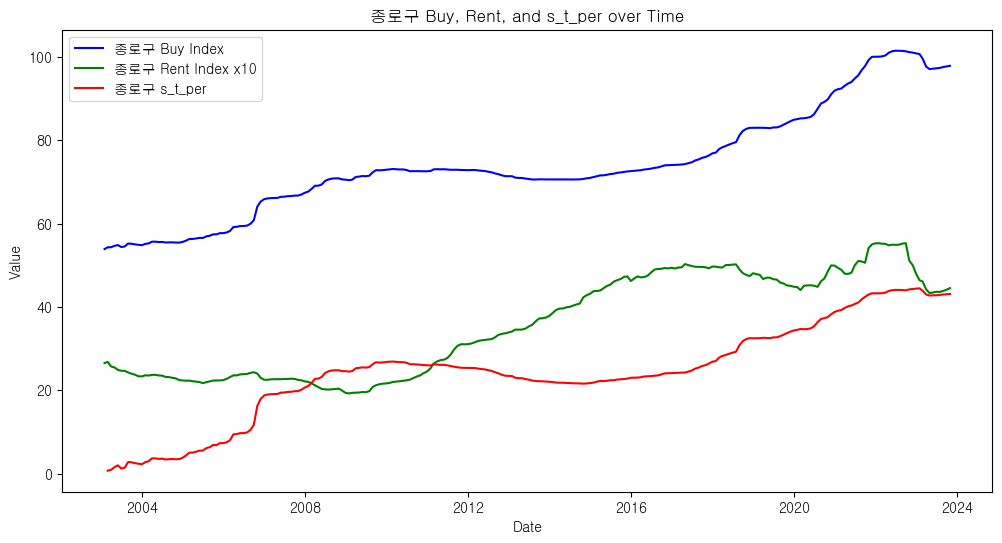

differential_evolution step 1: f(x)= 86.1405
differential_evolution step 2: f(x)= 86.1405
differential_evolution step 3: f(x)= 83.7369
differential_evolution step 4: f(x)= 69.2152
differential_evolution step 5: f(x)= 69.2152
differential_evolution step 6: f(x)= 69.2152
differential_evolution step 7: f(x)= 69.2152
differential_evolution step 8: f(x)= 69.2152
differential_evolution step 9: f(x)= 68.6754
differential_evolution step 10: f(x)= 68.5582
differential_evolution step 11: f(x)= 68.4143
differential_evolution step 12: f(x)= 68.4143
differential_evolution step 13: f(x)= 68.4143
differential_evolution step 14: f(x)= 68.4119
differential_evolution step 15: f(x)= 68.4119
differential_evolution step 16: f(x)= 68.4119
differential_evolution step 17: f(x)= 68.4009
differential_evolution step 18: f(x)= 68.4009
differential_evolution step 19: f(x)= 68.4009
differential_evolution step 20: f(x)= 68.392
differential_evolution step 21: f(x)= 68.392
differential_evolution step 22: f(x)= 68.392


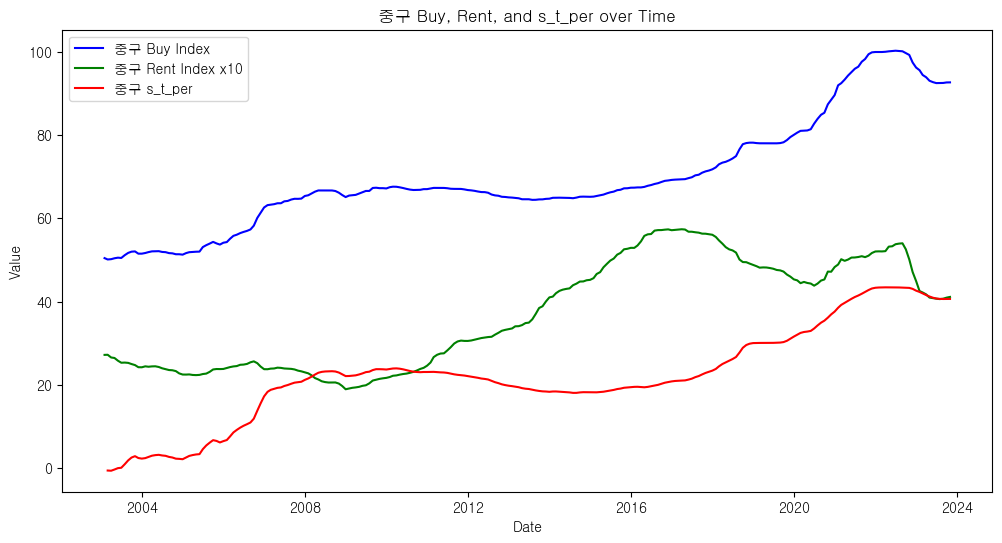

differential_evolution step 1: f(x)= 104.469
differential_evolution step 2: f(x)= 104.469
differential_evolution step 3: f(x)= 104.446
differential_evolution step 4: f(x)= 103.652
differential_evolution step 5: f(x)= 103.652
differential_evolution step 6: f(x)= 103.399
differential_evolution step 7: f(x)= 103.399
differential_evolution step 8: f(x)= 102.579
differential_evolution step 9: f(x)= 102.579
differential_evolution step 10: f(x)= 102.524
differential_evolution step 11: f(x)= 102.363
differential_evolution step 12: f(x)= 102.045
differential_evolution step 13: f(x)= 102.045
differential_evolution step 14: f(x)= 102.045
differential_evolution step 15: f(x)= 102.045
differential_evolution step 16: f(x)= 102.029
differential_evolution step 17: f(x)= 102.029
differential_evolution step 18: f(x)= 102.029
differential_evolution step 19: f(x)= 102.018
differential_evolution step 20: f(x)= 102.005
differential_evolution step 21: f(x)= 101.997
differential_evolution step 22: f(x)= 101.9

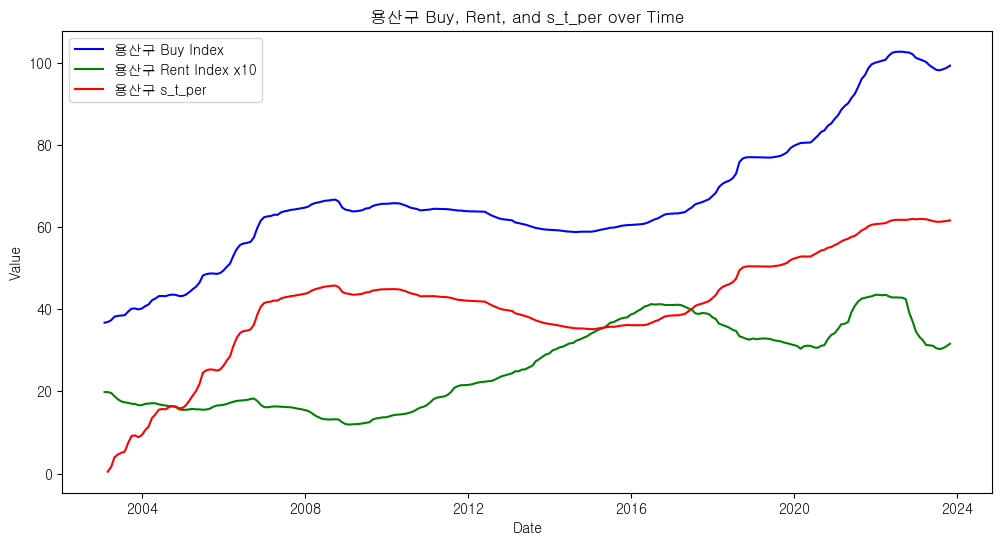

differential_evolution step 1: f(x)= 129.502
differential_evolution step 2: f(x)= 129.502
differential_evolution step 3: f(x)= 122.927
differential_evolution step 4: f(x)= 122.927
differential_evolution step 5: f(x)= 122.927
differential_evolution step 6: f(x)= 121.389
differential_evolution step 7: f(x)= 121.389
differential_evolution step 8: f(x)= 121.389
differential_evolution step 9: f(x)= 121.389
differential_evolution step 10: f(x)= 121.389
differential_evolution step 11: f(x)= 121.185
differential_evolution step 12: f(x)= 121.053
differential_evolution step 13: f(x)= 121.053
differential_evolution step 14: f(x)= 121.053
differential_evolution step 15: f(x)= 120.976
differential_evolution step 16: f(x)= 120.956
differential_evolution step 17: f(x)= 120.913
differential_evolution step 18: f(x)= 120.905
differential_evolution step 19: f(x)= 120.863
differential_evolution step 20: f(x)= 120.863
differential_evolution step 21: f(x)= 120.863
differential_evolution step 22: f(x)= 120.8

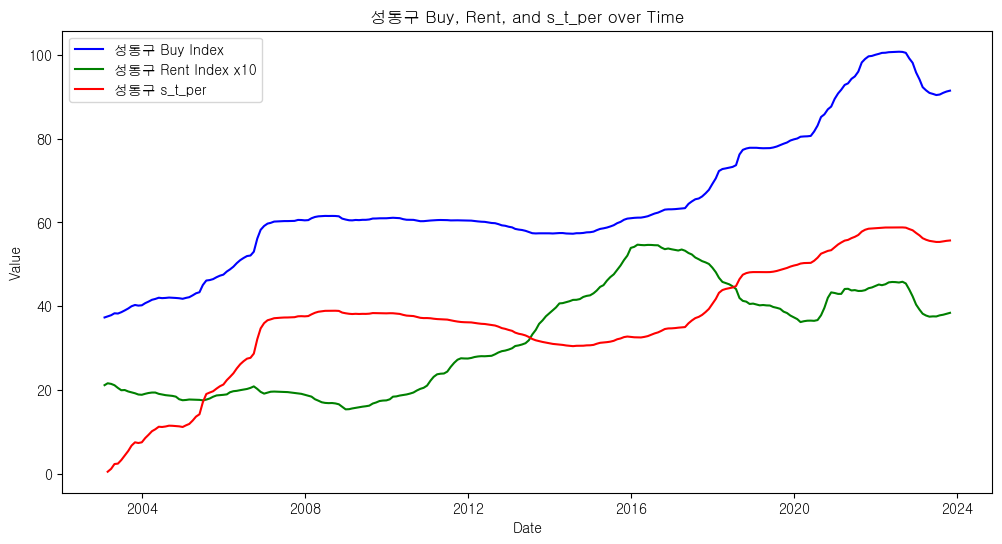

differential_evolution step 1: f(x)= 121.095
differential_evolution step 2: f(x)= 121.095
differential_evolution step 3: f(x)= 118.203
differential_evolution step 4: f(x)= 118.203
differential_evolution step 5: f(x)= 113.395
differential_evolution step 6: f(x)= 113.395
differential_evolution step 7: f(x)= 113.324
differential_evolution step 8: f(x)= 112.793
differential_evolution step 9: f(x)= 112.695
differential_evolution step 10: f(x)= 112.536
differential_evolution step 11: f(x)= 112.536
differential_evolution step 12: f(x)= 112.43
differential_evolution step 13: f(x)= 112.331
differential_evolution step 14: f(x)= 112.331
differential_evolution step 15: f(x)= 112.31
differential_evolution step 16: f(x)= 112.302
differential_evolution step 17: f(x)= 112.302
differential_evolution step 18: f(x)= 112.301
differential_evolution step 19: f(x)= 112.301
differential_evolution step 20: f(x)= 112.3
differential_evolution step 21: f(x)= 112.298
differential_evolution step 22: f(x)= 112.288
d

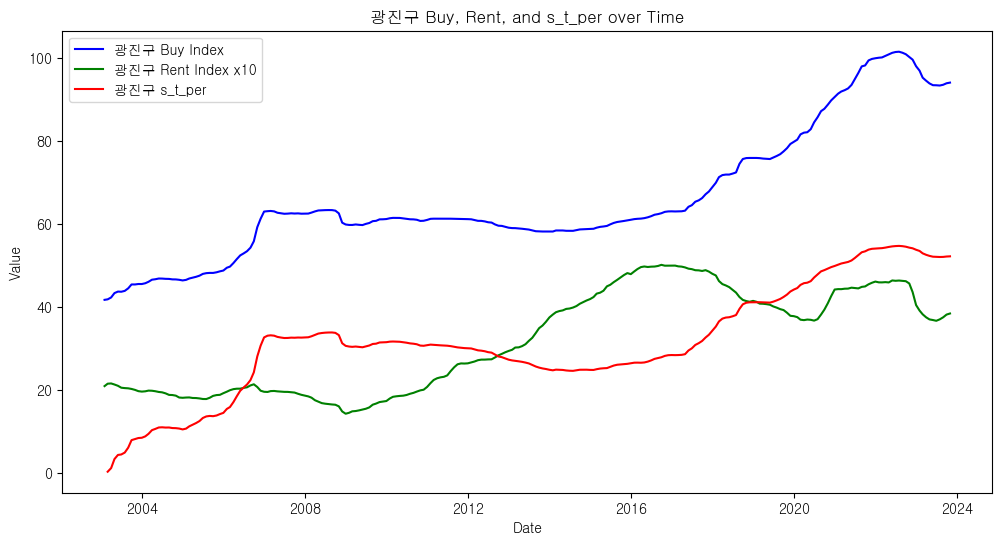

differential_evolution step 1: f(x)= 107.828
differential_evolution step 2: f(x)= 107.828
differential_evolution step 3: f(x)= 107.828
differential_evolution step 4: f(x)= 106.845
differential_evolution step 5: f(x)= 106.476
differential_evolution step 6: f(x)= 106.173
differential_evolution step 7: f(x)= 106.02
differential_evolution step 8: f(x)= 105.948
differential_evolution step 9: f(x)= 105.765
differential_evolution step 10: f(x)= 105.765
differential_evolution step 11: f(x)= 105.765
differential_evolution step 12: f(x)= 105.644
differential_evolution step 13: f(x)= 105.644
differential_evolution step 14: f(x)= 105.644
differential_evolution step 15: f(x)= 105.644
differential_evolution step 16: f(x)= 105.644
differential_evolution step 17: f(x)= 105.587
differential_evolution step 18: f(x)= 105.587
differential_evolution step 19: f(x)= 105.587
differential_evolution step 20: f(x)= 105.573
differential_evolution step 21: f(x)= 105.573
differential_evolution step 22: f(x)= 105.55

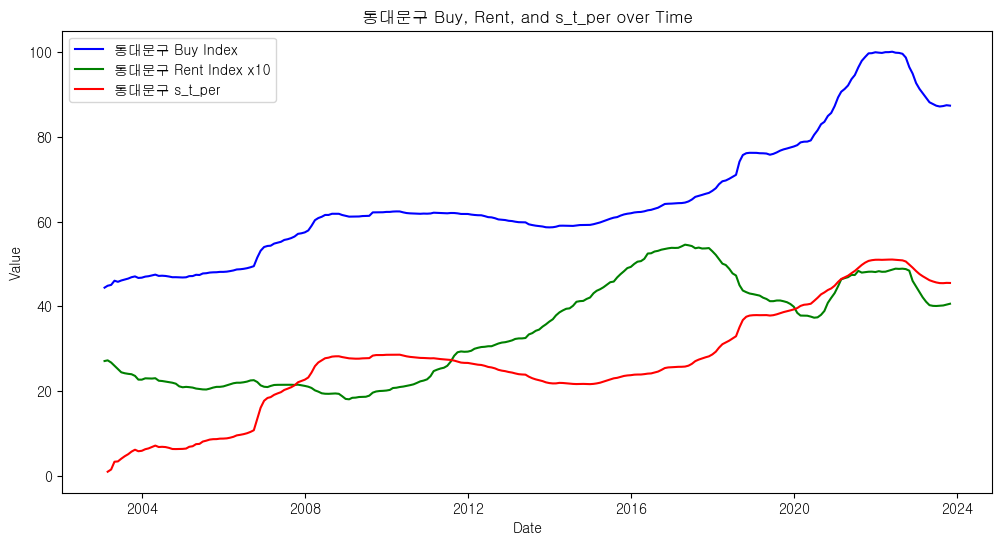

differential_evolution step 1: f(x)= 89.6358
differential_evolution step 2: f(x)= 88.6908
differential_evolution step 3: f(x)= 88.6908
differential_evolution step 4: f(x)= 82.9007
differential_evolution step 5: f(x)= 79.9644
differential_evolution step 6: f(x)= 79.2997
differential_evolution step 7: f(x)= 79.2118
differential_evolution step 8: f(x)= 78.969
differential_evolution step 9: f(x)= 77.2807
differential_evolution step 10: f(x)= 77.2807
differential_evolution step 11: f(x)= 77.037
differential_evolution step 12: f(x)= 77.037
differential_evolution step 13: f(x)= 77.037
differential_evolution step 14: f(x)= 77.037
differential_evolution step 15: f(x)= 77.037
differential_evolution step 16: f(x)= 76.9386
differential_evolution step 17: f(x)= 76.8256
differential_evolution step 18: f(x)= 76.8256
differential_evolution step 19: f(x)= 76.8256
differential_evolution step 20: f(x)= 76.8138
differential_evolution step 21: f(x)= 76.804
differential_evolution step 22: f(x)= 76.7938
diff

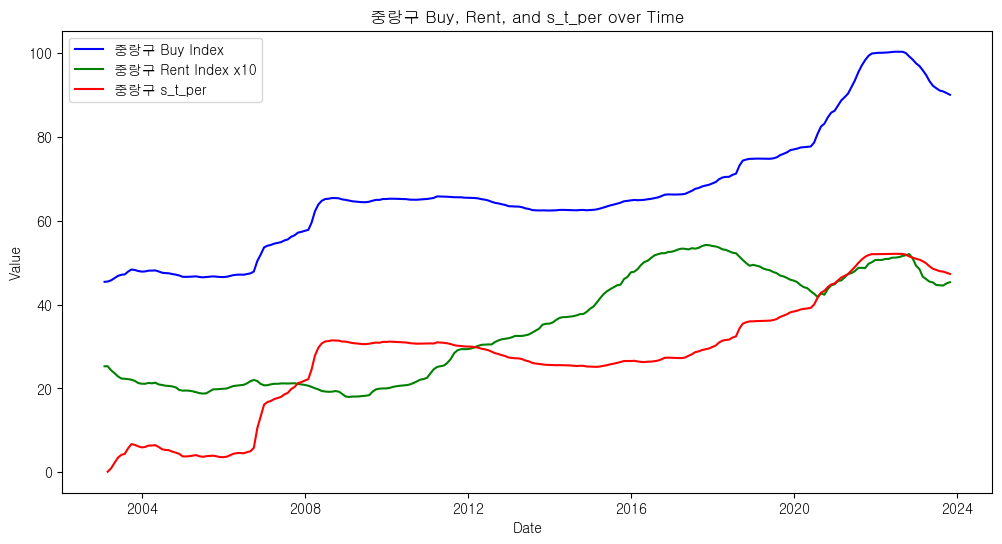

differential_evolution step 1: f(x)= 100.905
differential_evolution step 2: f(x)= 100.322
differential_evolution step 3: f(x)= 99.3321
differential_evolution step 4: f(x)= 97.9906
differential_evolution step 5: f(x)= 92.2488
differential_evolution step 6: f(x)= 92.2488
differential_evolution step 7: f(x)= 91.3355
differential_evolution step 8: f(x)= 91.3355
differential_evolution step 9: f(x)= 91.3355
differential_evolution step 10: f(x)= 91.3355
differential_evolution step 11: f(x)= 91.2072
differential_evolution step 12: f(x)= 91.1743
differential_evolution step 13: f(x)= 91.1743
differential_evolution step 14: f(x)= 91.1728
differential_evolution step 15: f(x)= 91.1042
differential_evolution step 16: f(x)= 91.1042
differential_evolution step 17: f(x)= 91.1042
differential_evolution step 18: f(x)= 91.1042
differential_evolution step 19: f(x)= 91.1042
differential_evolution step 20: f(x)= 91.1005
differential_evolution step 21: f(x)= 91.1005
differential_evolution step 22: f(x)= 91.08

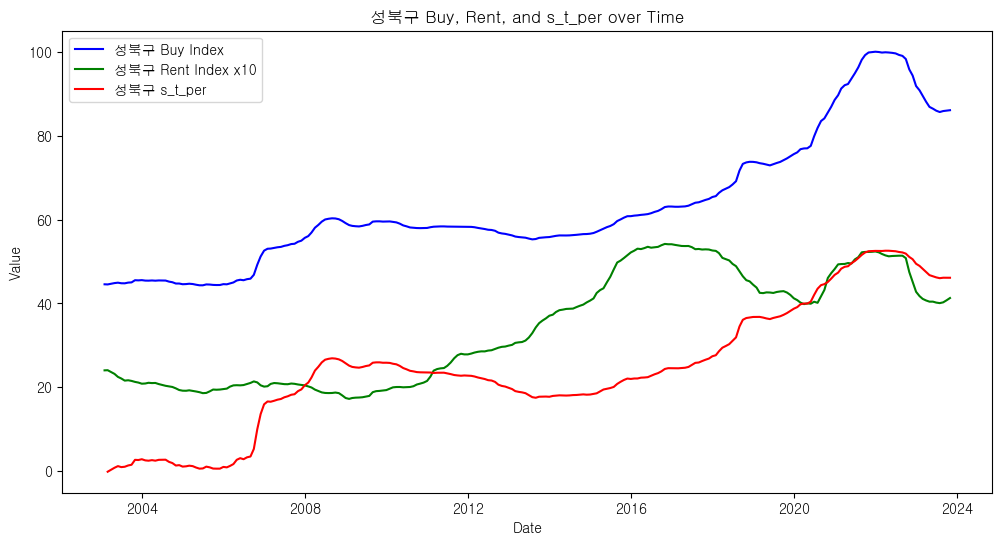

differential_evolution step 1: f(x)= 144.534
differential_evolution step 2: f(x)= 141.665
differential_evolution step 3: f(x)= 140.653
differential_evolution step 4: f(x)= 140.653
differential_evolution step 5: f(x)= 139.725
differential_evolution step 6: f(x)= 139.725
differential_evolution step 7: f(x)= 139.169
differential_evolution step 8: f(x)= 138.647
differential_evolution step 9: f(x)= 138.647
differential_evolution step 10: f(x)= 138.647
differential_evolution step 11: f(x)= 138.26
differential_evolution step 12: f(x)= 138.26
differential_evolution step 13: f(x)= 138.022
differential_evolution step 14: f(x)= 137.936
differential_evolution step 15: f(x)= 137.752
differential_evolution step 16: f(x)= 137.75
differential_evolution step 17: f(x)= 137.75
differential_evolution step 18: f(x)= 137.696
differential_evolution step 19: f(x)= 137.637
differential_evolution step 20: f(x)= 137.637
differential_evolution step 21: f(x)= 137.637
differential_evolution step 22: f(x)= 137.637
d

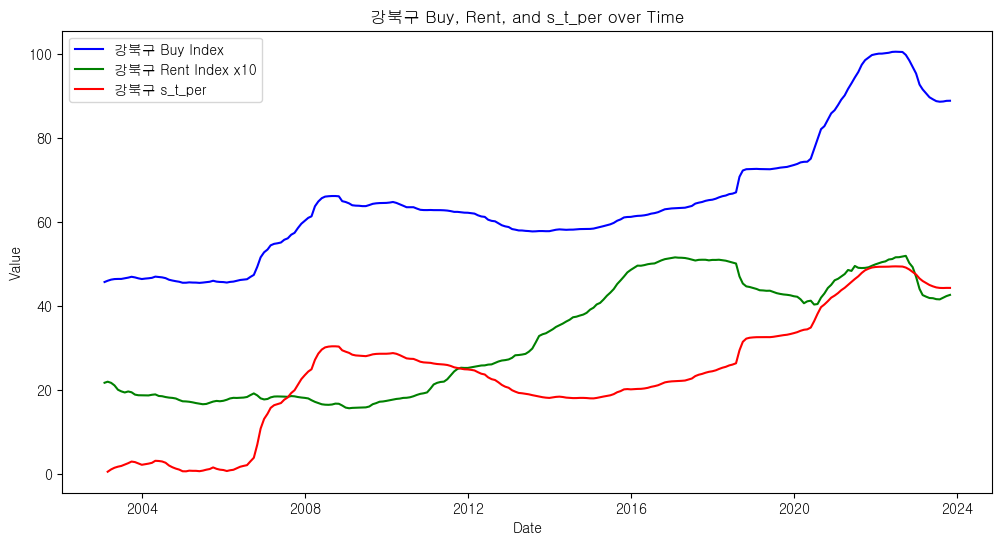

differential_evolution step 1: f(x)= 153.334
differential_evolution step 2: f(x)= 143.235
differential_evolution step 3: f(x)= 143.235
differential_evolution step 4: f(x)= 143.235
differential_evolution step 5: f(x)= 142.028
differential_evolution step 6: f(x)= 142.028
differential_evolution step 7: f(x)= 142.028
differential_evolution step 8: f(x)= 142.028
differential_evolution step 9: f(x)= 142.028
differential_evolution step 10: f(x)= 142.028
differential_evolution step 11: f(x)= 141.66
differential_evolution step 12: f(x)= 141.66
differential_evolution step 13: f(x)= 141.66
differential_evolution step 14: f(x)= 141.634
differential_evolution step 15: f(x)= 141.616
differential_evolution step 16: f(x)= 141.616
differential_evolution step 17: f(x)= 141.604
differential_evolution step 18: f(x)= 141.604
differential_evolution step 19: f(x)= 141.604
differential_evolution step 20: f(x)= 141.601
differential_evolution step 21: f(x)= 141.601
differential_evolution step 22: f(x)= 141.589


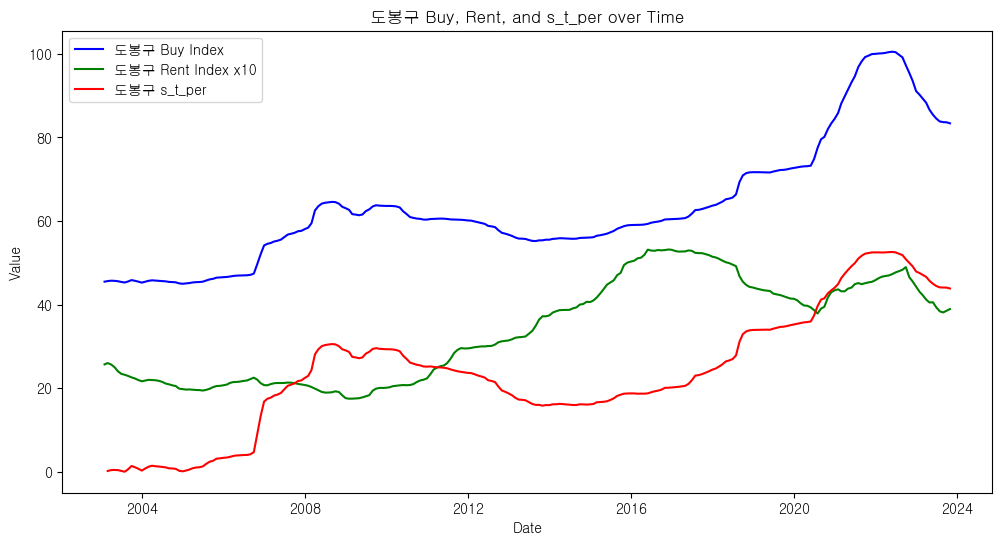

differential_evolution step 1: f(x)= 168.43
differential_evolution step 2: f(x)= 160.334
differential_evolution step 3: f(x)= 160.334
differential_evolution step 4: f(x)= 160.334
differential_evolution step 5: f(x)= 160.334
differential_evolution step 6: f(x)= 160.334
differential_evolution step 7: f(x)= 160.131
differential_evolution step 8: f(x)= 159.928
differential_evolution step 9: f(x)= 158.846
differential_evolution step 10: f(x)= 158.604
differential_evolution step 11: f(x)= 158.604
differential_evolution step 12: f(x)= 158.524
differential_evolution step 13: f(x)= 158.475
differential_evolution step 14: f(x)= 158.475
differential_evolution step 15: f(x)= 158.37
differential_evolution step 16: f(x)= 158.329
differential_evolution step 17: f(x)= 158.329
differential_evolution step 18: f(x)= 158.312
differential_evolution step 19: f(x)= 158.312
differential_evolution step 20: f(x)= 158.312
differential_evolution step 21: f(x)= 158.312
differential_evolution step 22: f(x)= 158.312

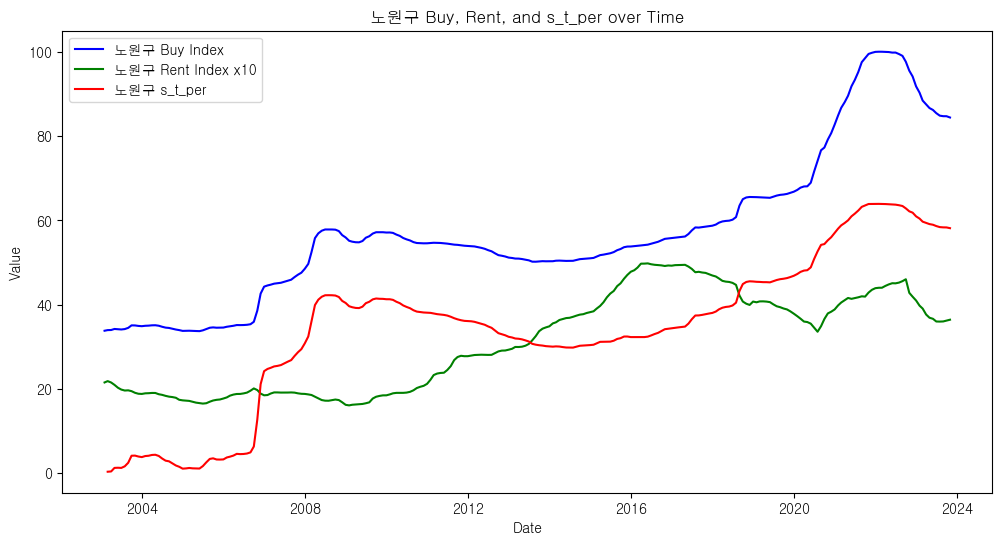

differential_evolution step 1: f(x)= 78.5133
differential_evolution step 2: f(x)= 78.5133
differential_evolution step 3: f(x)= 78.5133
differential_evolution step 4: f(x)= 78.5133
differential_evolution step 5: f(x)= 78.5133
differential_evolution step 6: f(x)= 78.5133
differential_evolution step 7: f(x)= 77.8865
differential_evolution step 8: f(x)= 77.8865
differential_evolution step 9: f(x)= 77.8865
differential_evolution step 10: f(x)= 77.8788
differential_evolution step 11: f(x)= 77.697
differential_evolution step 12: f(x)= 77.697
differential_evolution step 13: f(x)= 77.6022
differential_evolution step 14: f(x)= 77.5768
differential_evolution step 15: f(x)= 77.5768
differential_evolution step 16: f(x)= 77.5486
differential_evolution step 17: f(x)= 77.5486
differential_evolution step 18: f(x)= 77.5326
differential_evolution step 19: f(x)= 77.5326
differential_evolution step 20: f(x)= 77.5326
differential_evolution step 21: f(x)= 77.5207
differential_evolution step 22: f(x)= 77.5207

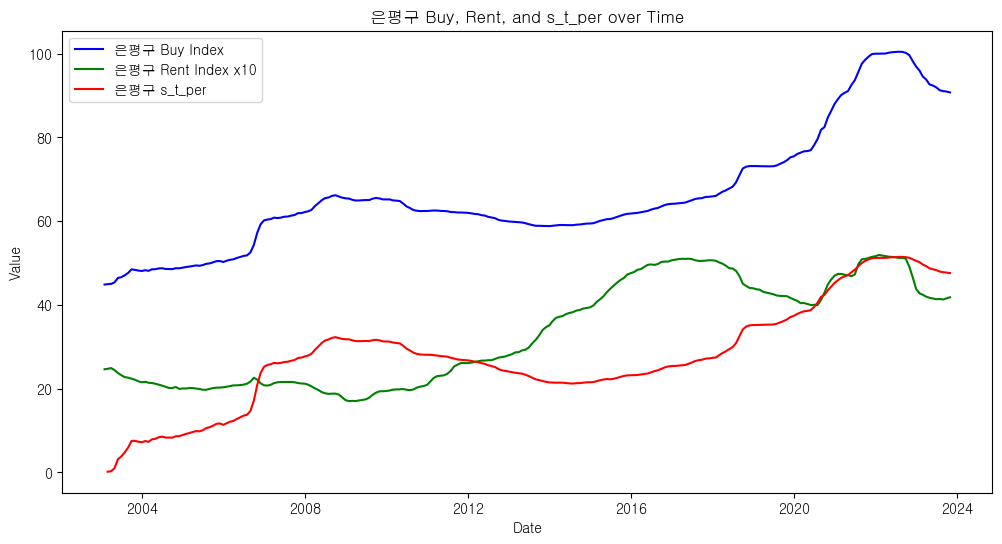

differential_evolution step 1: f(x)= 52.9943
differential_evolution step 2: f(x)= 52.9943
differential_evolution step 3: f(x)= 52.9943
differential_evolution step 4: f(x)= 52.9943
differential_evolution step 5: f(x)= 44.6333
differential_evolution step 6: f(x)= 44.6333
differential_evolution step 7: f(x)= 44.6333
differential_evolution step 8: f(x)= 44.6333
differential_evolution step 9: f(x)= 42.1293
differential_evolution step 10: f(x)= 42.1293
differential_evolution step 11: f(x)= 42.1293
differential_evolution step 12: f(x)= 42.1293
differential_evolution step 13: f(x)= 41.9967
differential_evolution step 14: f(x)= 41.8779
differential_evolution step 15: f(x)= 41.8779
differential_evolution step 16: f(x)= 41.8779
differential_evolution step 17: f(x)= 41.7667
differential_evolution step 18: f(x)= 41.7567
differential_evolution step 19: f(x)= 41.7357
differential_evolution step 20: f(x)= 41.6727
differential_evolution step 21: f(x)= 41.6727
differential_evolution step 22: f(x)= 41.67

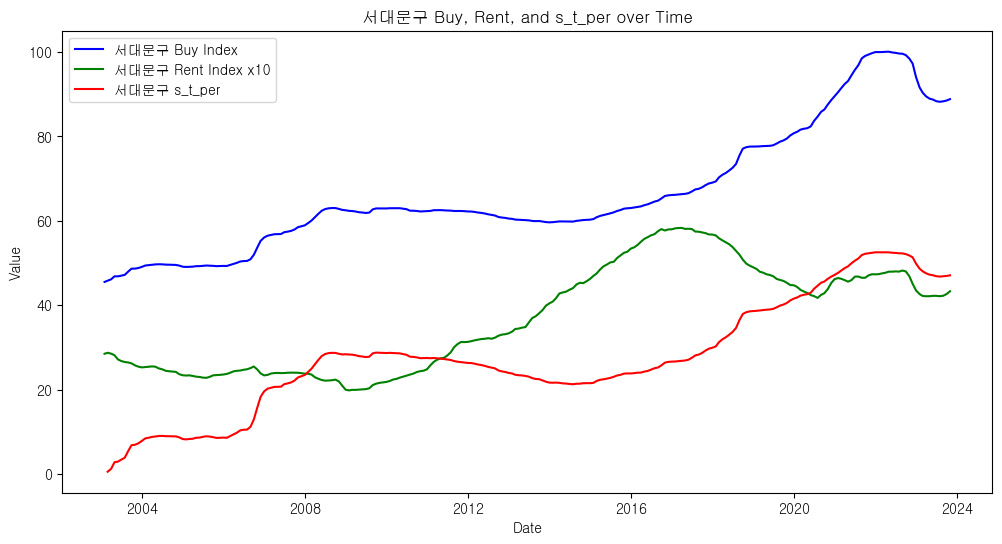

differential_evolution step 1: f(x)= 126.289
differential_evolution step 2: f(x)= 107.867
differential_evolution step 3: f(x)= 105.565
differential_evolution step 4: f(x)= 101.473
differential_evolution step 5: f(x)= 101.473
differential_evolution step 6: f(x)= 101.473
differential_evolution step 7: f(x)= 101.473
differential_evolution step 8: f(x)= 101.473
differential_evolution step 9: f(x)= 100.978
differential_evolution step 10: f(x)= 100.978
differential_evolution step 11: f(x)= 100.946
differential_evolution step 12: f(x)= 100.779
differential_evolution step 13: f(x)= 100.779
differential_evolution step 14: f(x)= 100.779
differential_evolution step 15: f(x)= 100.777
differential_evolution step 16: f(x)= 100.752
differential_evolution step 17: f(x)= 100.752
differential_evolution step 18: f(x)= 100.752
differential_evolution step 19: f(x)= 100.752
differential_evolution step 20: f(x)= 100.751
differential_evolution step 21: f(x)= 100.749
differential_evolution step 22: f(x)= 100.7

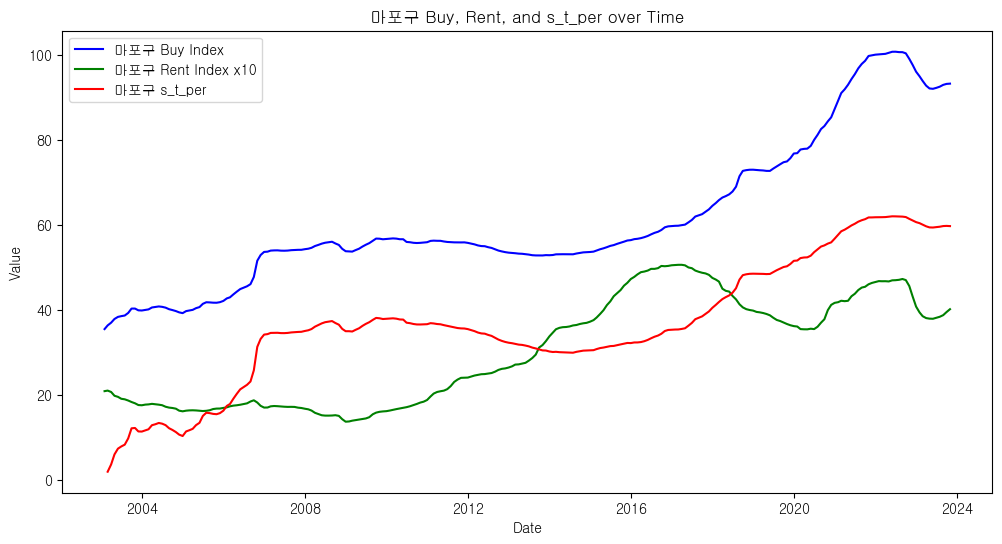

differential_evolution step 1: f(x)= 158.487
differential_evolution step 2: f(x)= 158.487
differential_evolution step 3: f(x)= 158.487
differential_evolution step 4: f(x)= 157.911
differential_evolution step 5: f(x)= 157.911
differential_evolution step 6: f(x)= 157.911
differential_evolution step 7: f(x)= 155.805
differential_evolution step 8: f(x)= 155.686
differential_evolution step 9: f(x)= 155.059
differential_evolution step 10: f(x)= 155.059
differential_evolution step 11: f(x)= 155.059
differential_evolution step 12: f(x)= 155.059
differential_evolution step 13: f(x)= 155.059
differential_evolution step 14: f(x)= 155.059
differential_evolution step 15: f(x)= 155.059
differential_evolution step 16: f(x)= 155.059
differential_evolution step 17: f(x)= 154.985
differential_evolution step 18: f(x)= 154.942
differential_evolution step 19: f(x)= 154.909
differential_evolution step 20: f(x)= 154.909
differential_evolution step 21: f(x)= 154.89
differential_evolution step 22: f(x)= 154.88

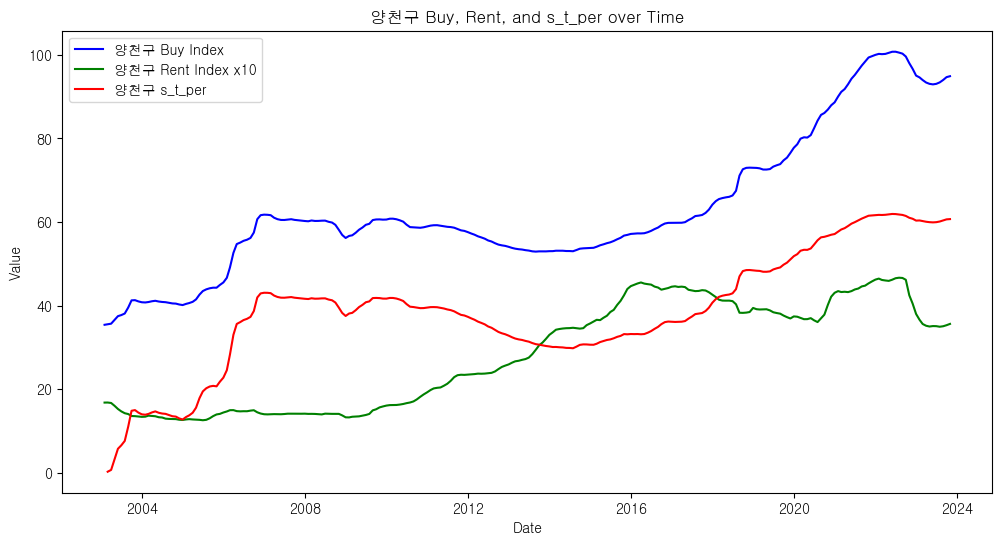

differential_evolution step 1: f(x)= 113.61
differential_evolution step 2: f(x)= 106.023
differential_evolution step 3: f(x)= 106.023
differential_evolution step 4: f(x)= 105.954
differential_evolution step 5: f(x)= 105.954
differential_evolution step 6: f(x)= 105.2
differential_evolution step 7: f(x)= 104.593
differential_evolution step 8: f(x)= 104.593
differential_evolution step 9: f(x)= 104.263
differential_evolution step 10: f(x)= 104.263
differential_evolution step 11: f(x)= 104.263
differential_evolution step 12: f(x)= 104.263
differential_evolution step 13: f(x)= 104.049
differential_evolution step 14: f(x)= 104.049
differential_evolution step 15: f(x)= 104.049
differential_evolution step 16: f(x)= 103.975
differential_evolution step 17: f(x)= 103.946
differential_evolution step 18: f(x)= 103.897
differential_evolution step 19: f(x)= 103.897
differential_evolution step 20: f(x)= 103.897
differential_evolution step 21: f(x)= 103.897
differential_evolution step 22: f(x)= 103.897


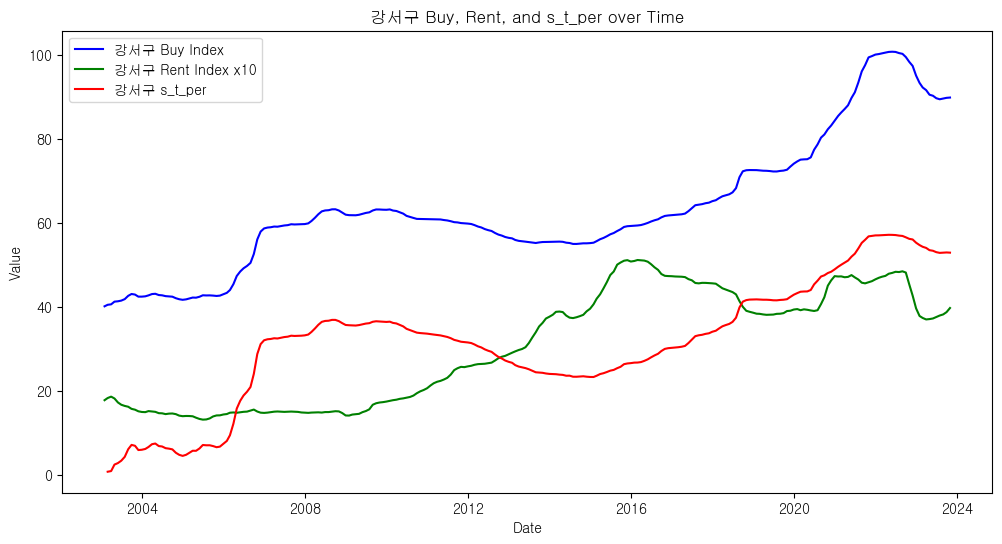

differential_evolution step 1: f(x)= 114.269
differential_evolution step 2: f(x)= 109.352
differential_evolution step 3: f(x)= 108.507
differential_evolution step 4: f(x)= 108.507
differential_evolution step 5: f(x)= 108.507
differential_evolution step 6: f(x)= 108.218
differential_evolution step 7: f(x)= 107.876
differential_evolution step 8: f(x)= 107.876
differential_evolution step 9: f(x)= 107.876
differential_evolution step 10: f(x)= 107.876
differential_evolution step 11: f(x)= 107.762
differential_evolution step 12: f(x)= 107.649
differential_evolution step 13: f(x)= 107.649
differential_evolution step 14: f(x)= 107.649
differential_evolution step 15: f(x)= 107.649
differential_evolution step 16: f(x)= 107.628
differential_evolution step 17: f(x)= 107.628
differential_evolution step 18: f(x)= 107.628
differential_evolution step 19: f(x)= 107.628
differential_evolution step 20: f(x)= 107.628
differential_evolution step 21: f(x)= 107.619
differential_evolution step 22: f(x)= 107.6

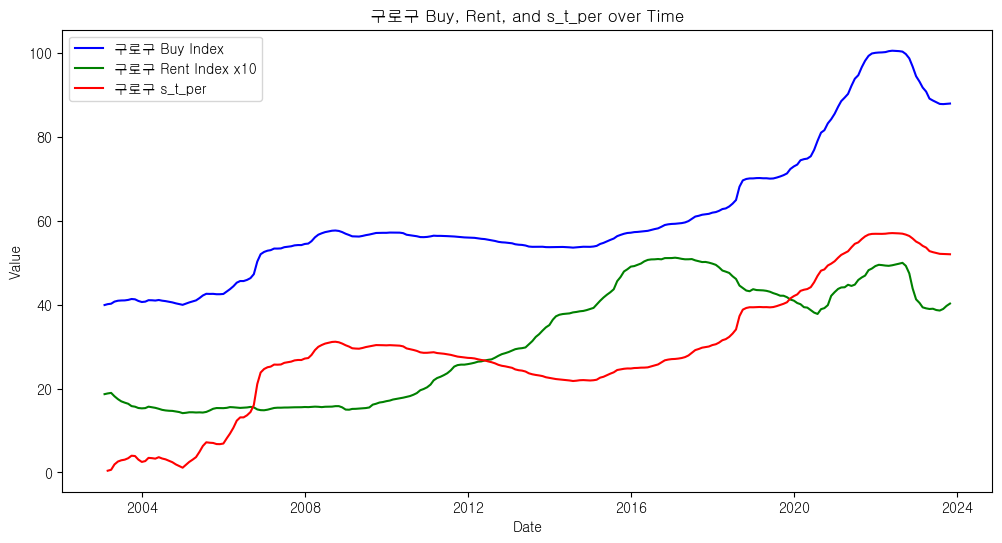

differential_evolution step 1: f(x)= 127.498
differential_evolution step 2: f(x)= 127.498
differential_evolution step 3: f(x)= 114.716
differential_evolution step 4: f(x)= 114.716
differential_evolution step 5: f(x)= 113.355
differential_evolution step 6: f(x)= 113.355
differential_evolution step 7: f(x)= 113.355
differential_evolution step 8: f(x)= 113.173
differential_evolution step 9: f(x)= 113.037
differential_evolution step 10: f(x)= 113.037
differential_evolution step 11: f(x)= 113.037
differential_evolution step 12: f(x)= 113.037
differential_evolution step 13: f(x)= 113.017
differential_evolution step 14: f(x)= 112.999
differential_evolution step 15: f(x)= 112.999
differential_evolution step 16: f(x)= 112.983
differential_evolution step 17: f(x)= 112.983
differential_evolution step 18: f(x)= 112.983
differential_evolution step 19: f(x)= 112.976
differential_evolution step 20: f(x)= 112.974
differential_evolution step 21: f(x)= 112.974
differential_evolution step 22: f(x)= 112.9

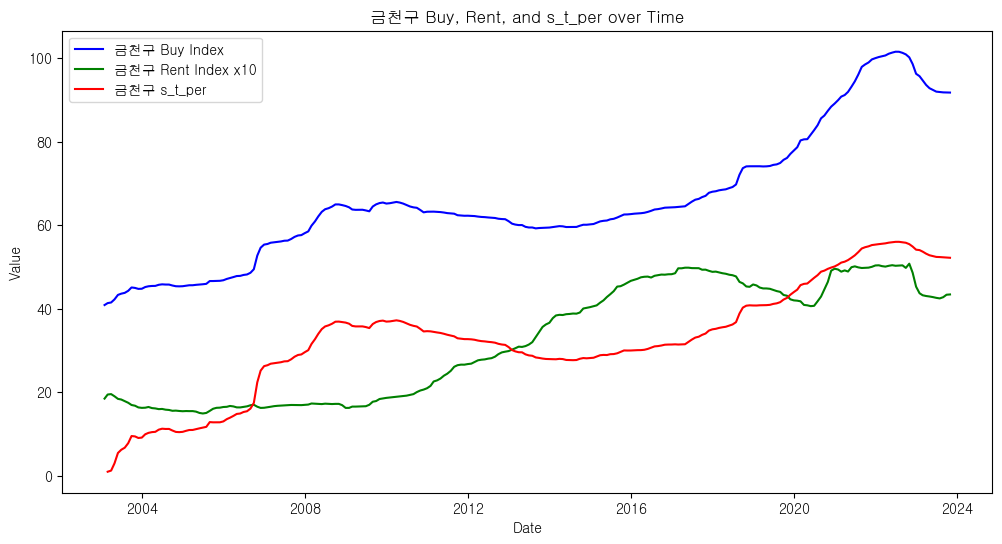

differential_evolution step 1: f(x)= 68.7205
differential_evolution step 2: f(x)= 68.7205
differential_evolution step 3: f(x)= 68.7205
differential_evolution step 4: f(x)= 68.7205
differential_evolution step 5: f(x)= 66.8352
differential_evolution step 6: f(x)= 66.084
differential_evolution step 7: f(x)= 65.9365
differential_evolution step 8: f(x)= 64.2262
differential_evolution step 9: f(x)= 64.2262
differential_evolution step 10: f(x)= 64.2262
differential_evolution step 11: f(x)= 64.2262
differential_evolution step 12: f(x)= 63.8102
differential_evolution step 13: f(x)= 63.8102
differential_evolution step 14: f(x)= 63.8102
differential_evolution step 15: f(x)= 63.8102
differential_evolution step 16: f(x)= 63.6038
differential_evolution step 17: f(x)= 63.6038
differential_evolution step 18: f(x)= 63.5335
differential_evolution step 19: f(x)= 63.5335
differential_evolution step 20: f(x)= 63.527
differential_evolution step 21: f(x)= 63.5255
differential_evolution step 22: f(x)= 63.5255

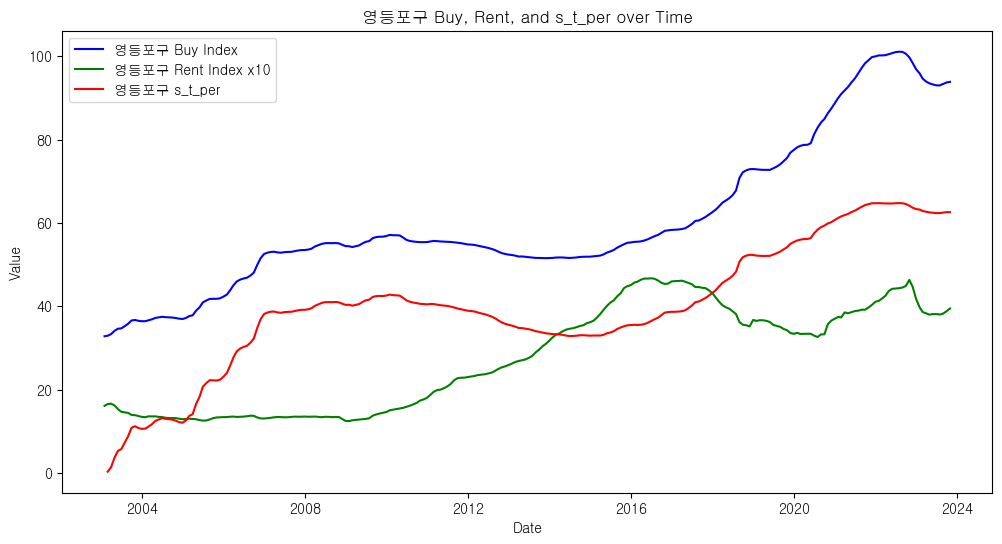

differential_evolution step 1: f(x)= 124.605
differential_evolution step 2: f(x)= 124.605
differential_evolution step 3: f(x)= 122.202
differential_evolution step 4: f(x)= 122.202
differential_evolution step 5: f(x)= 122.202
differential_evolution step 6: f(x)= 122.202
differential_evolution step 7: f(x)= 121.842
differential_evolution step 8: f(x)= 121.842
differential_evolution step 9: f(x)= 121.303
differential_evolution step 10: f(x)= 121.303
differential_evolution step 11: f(x)= 121.303
differential_evolution step 12: f(x)= 121.303
differential_evolution step 13: f(x)= 121.26
differential_evolution step 14: f(x)= 120.993
differential_evolution step 15: f(x)= 120.993
differential_evolution step 16: f(x)= 120.993
differential_evolution step 17: f(x)= 120.993
differential_evolution step 18: f(x)= 120.993
differential_evolution step 19: f(x)= 120.992
differential_evolution step 20: f(x)= 120.938
differential_evolution step 21: f(x)= 120.938
differential_evolution step 22: f(x)= 120.90

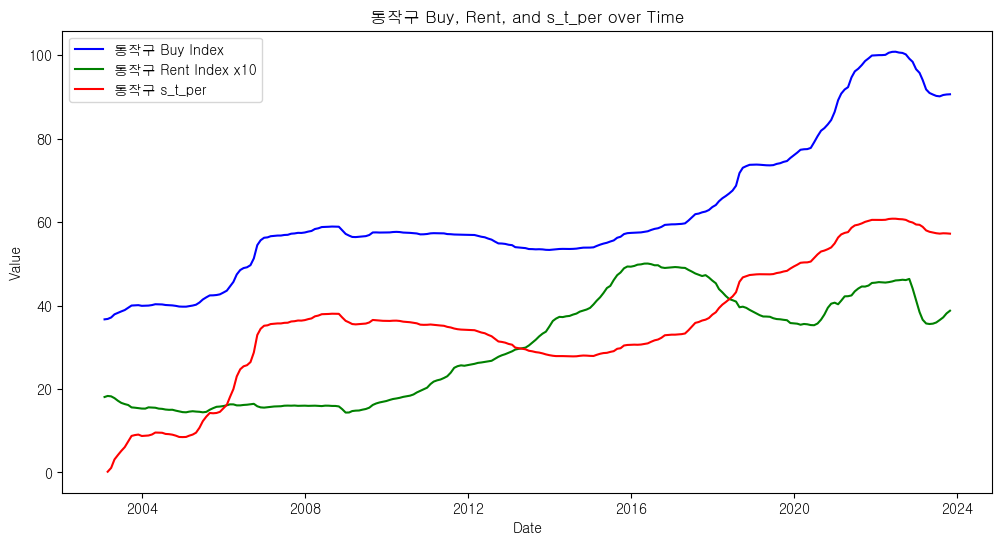

differential_evolution step 1: f(x)= 94.2634
differential_evolution step 2: f(x)= 94.2634
differential_evolution step 3: f(x)= 94.2634
differential_evolution step 4: f(x)= 94.1539
differential_evolution step 5: f(x)= 88.091
differential_evolution step 6: f(x)= 85.8562
differential_evolution step 7: f(x)= 85.8562
differential_evolution step 8: f(x)= 85.3235
differential_evolution step 9: f(x)= 85.0089
differential_evolution step 10: f(x)= 85.0089
differential_evolution step 11: f(x)= 85.0089
differential_evolution step 12: f(x)= 84.948
differential_evolution step 13: f(x)= 84.948
differential_evolution step 14: f(x)= 84.948
differential_evolution step 15: f(x)= 84.9387
differential_evolution step 16: f(x)= 84.9387
differential_evolution step 17: f(x)= 84.936
differential_evolution step 18: f(x)= 84.8844
differential_evolution step 19: f(x)= 84.8844
differential_evolution step 20: f(x)= 84.8844
differential_evolution step 21: f(x)= 84.8844
differential_evolution step 22: f(x)= 84.8751
di

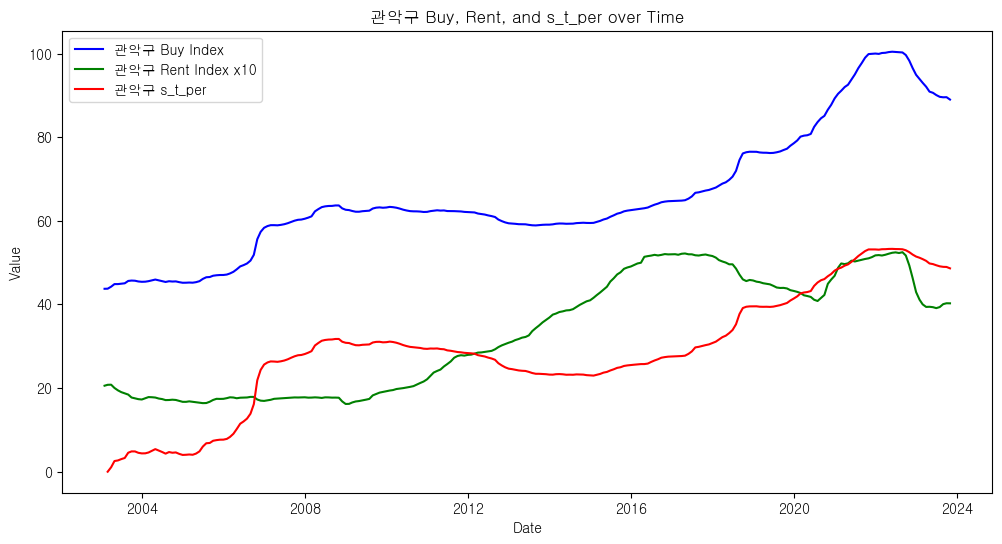

differential_evolution step 1: f(x)= 183.922
differential_evolution step 2: f(x)= 179.365
differential_evolution step 3: f(x)= 170.603
differential_evolution step 4: f(x)= 169.98
differential_evolution step 5: f(x)= 169.98
differential_evolution step 6: f(x)= 169.751
differential_evolution step 7: f(x)= 169.09
differential_evolution step 8: f(x)= 169.09
differential_evolution step 9: f(x)= 168.986
differential_evolution step 10: f(x)= 168.751
differential_evolution step 11: f(x)= 168.751
differential_evolution step 12: f(x)= 168.323
differential_evolution step 13: f(x)= 168.172
differential_evolution step 14: f(x)= 168.172
differential_evolution step 15: f(x)= 168.172
differential_evolution step 16: f(x)= 168.07
differential_evolution step 17: f(x)= 168.07
differential_evolution step 18: f(x)= 168.057
differential_evolution step 19: f(x)= 168.057
differential_evolution step 20: f(x)= 168.057
differential_evolution step 21: f(x)= 168.037
differential_evolution step 22: f(x)= 168.032
dif

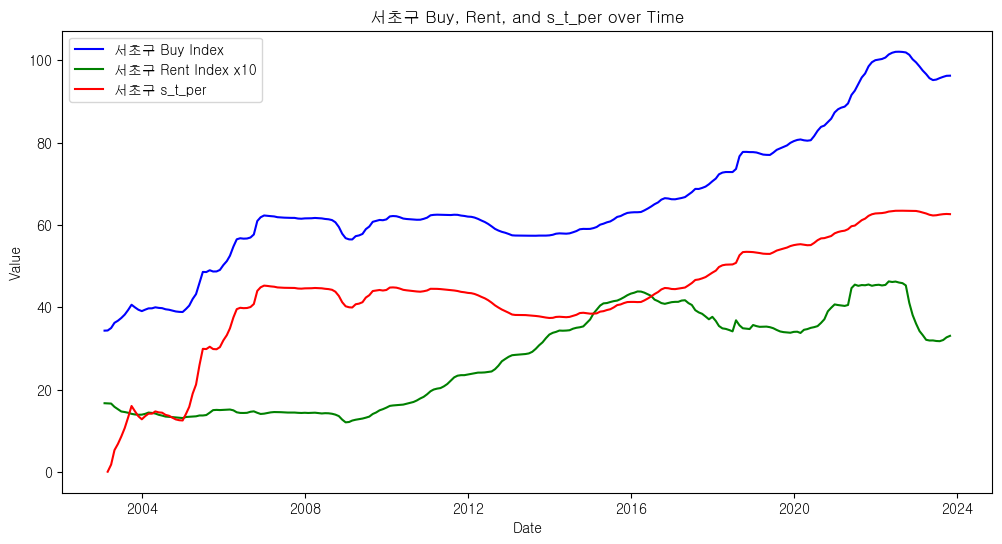

differential_evolution step 1: f(x)= 215.342
differential_evolution step 2: f(x)= 199.633
differential_evolution step 3: f(x)= 197.917
differential_evolution step 4: f(x)= 189.424
differential_evolution step 5: f(x)= 189.424
differential_evolution step 6: f(x)= 189.424
differential_evolution step 7: f(x)= 189.424
differential_evolution step 8: f(x)= 189.09
differential_evolution step 9: f(x)= 188.845
differential_evolution step 10: f(x)= 188.845
differential_evolution step 11: f(x)= 188.845
differential_evolution step 12: f(x)= 188.845
differential_evolution step 13: f(x)= 188.845
differential_evolution step 14: f(x)= 188.797
differential_evolution step 15: f(x)= 188.797
differential_evolution step 16: f(x)= 188.734
differential_evolution step 17: f(x)= 188.734
differential_evolution step 18: f(x)= 188.734
differential_evolution step 19: f(x)= 188.723
differential_evolution step 20: f(x)= 188.723
differential_evolution step 21: f(x)= 188.719
differential_evolution step 22: f(x)= 188.70

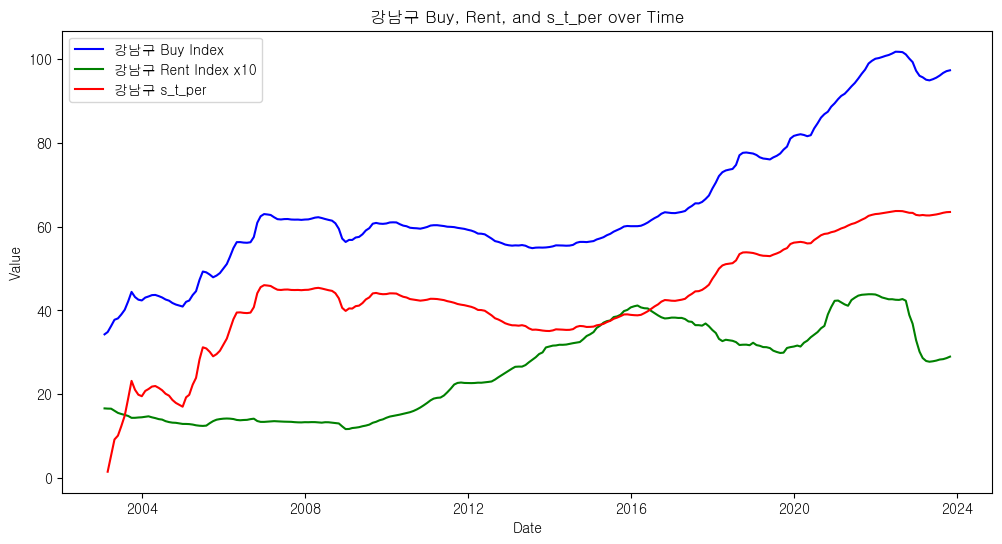

differential_evolution step 1: f(x)= 212.881
differential_evolution step 2: f(x)= 212.881
differential_evolution step 3: f(x)= 210.711
differential_evolution step 4: f(x)= 210.711
differential_evolution step 5: f(x)= 206.929
differential_evolution step 6: f(x)= 206.929
differential_evolution step 7: f(x)= 206.114
differential_evolution step 8: f(x)= 206.114
differential_evolution step 9: f(x)= 205.757
differential_evolution step 10: f(x)= 205.454
differential_evolution step 11: f(x)= 205.339
differential_evolution step 12: f(x)= 205.339
differential_evolution step 13: f(x)= 205.339
differential_evolution step 14: f(x)= 205.318
differential_evolution step 15: f(x)= 204.613
differential_evolution step 16: f(x)= 204.613
differential_evolution step 17: f(x)= 204.613
differential_evolution step 18: f(x)= 204.558
differential_evolution step 19: f(x)= 204.558
differential_evolution step 20: f(x)= 204.558
differential_evolution step 21: f(x)= 204.507
differential_evolution step 22: f(x)= 204.5

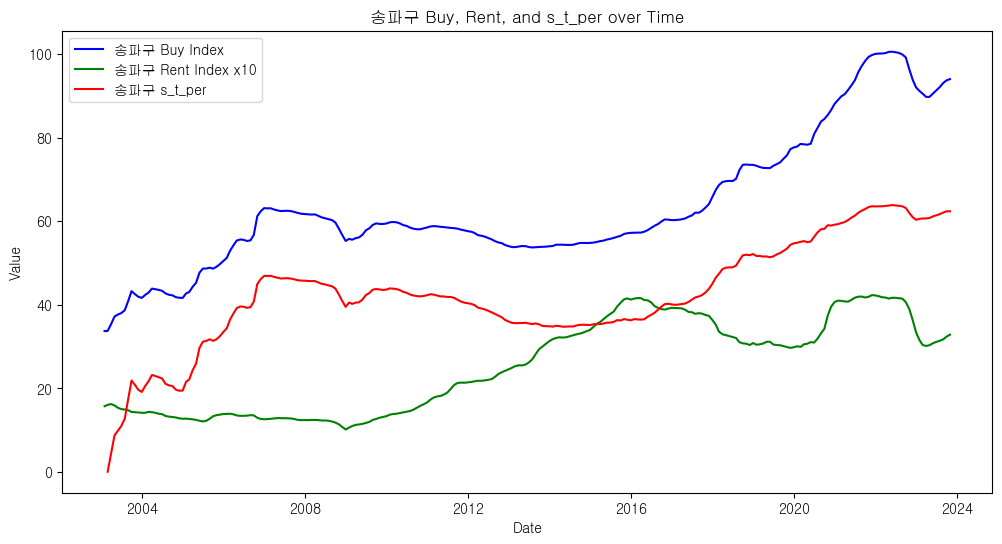

differential_evolution step 1: f(x)= 249.248
differential_evolution step 2: f(x)= 245.549
differential_evolution step 3: f(x)= 241.325
differential_evolution step 4: f(x)= 241.325
differential_evolution step 5: f(x)= 241.325
differential_evolution step 6: f(x)= 241.325
differential_evolution step 7: f(x)= 241.325
differential_evolution step 8: f(x)= 241.314
differential_evolution step 9: f(x)= 241.155
differential_evolution step 10: f(x)= 240.541
differential_evolution step 11: f(x)= 240.408
differential_evolution step 12: f(x)= 240.097
differential_evolution step 13: f(x)= 240.089
differential_evolution step 14: f(x)= 240.089
differential_evolution step 15: f(x)= 240.089
differential_evolution step 16: f(x)= 240.089
differential_evolution step 17: f(x)= 240.089
differential_evolution step 18: f(x)= 240.049
differential_evolution step 19: f(x)= 240.029
differential_evolution step 20: f(x)= 240.029
differential_evolution step 21: f(x)= 240.029
differential_evolution step 22: f(x)= 240.0

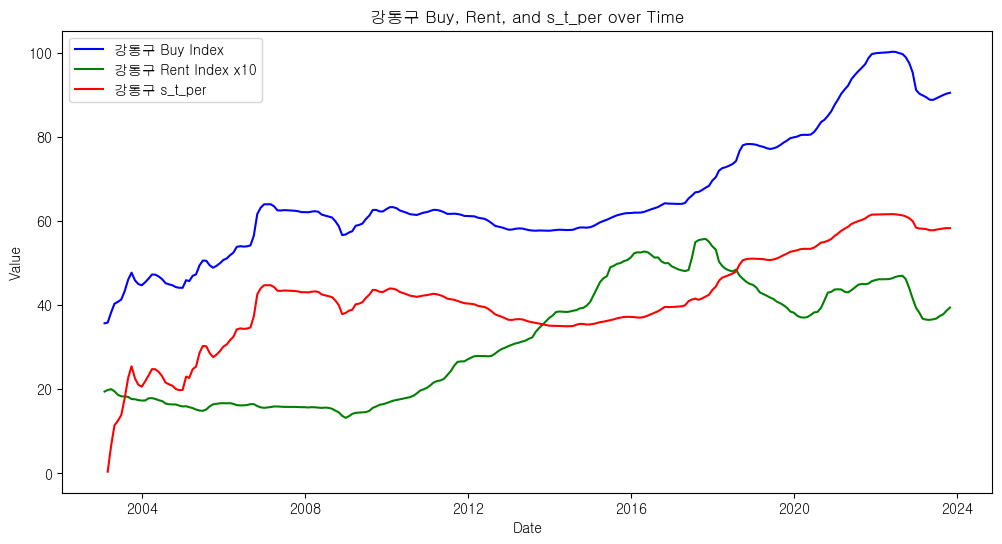

In [20]:
def analyze_district(buy_data, rent_data, district_name, results_dict):
    buy_temp = pd.Series(buy_data[district_name].copy())
    rent_temp = pd.Series(rent_data[district_name].copy())
    y = buy_temp.diff().dropna() 
    x = rent_temp.diff().dropna()

    estimated_theta = estimate_parameters(y, x)
    beta, phi, sigma_b, sigma_s, sigma_zeta = estimated_theta
    rho = 1 / beta
    psi = 1 / (1 - phi * rho)
    z_estimates = run_kalman_filter(y, x, estimated_theta)

    # Extract delta b_t and calculate s_t
    Delta_s_t_series = [z[0] for z in z_estimates]
    initial_s_t = 0
    s_t_series = np.cumsum(np.insert(Delta_s_t_series, 0, initial_s_t))
    s_t_per = s_t_series / buy_temp[1:] * 100
    
    # Save s_t_per results
    results_dict[district_name] = s_t_per[1:] 

    # Create a DataFrame
    df = pd.DataFrame({
        f'{district_name} Buy Index': buy_temp.iloc[1:], 
        f'{district_name} Rent Index': rent_temp.iloc[1:] * 10,
        f'{district_name} s_t_per': s_t_per[1:] 
    }, index=buy_temp.index[1:]) 

    plt.figure(figsize=(12, 6))
    plt.plot(df.index, df[f'{district_name} Buy Index'], label=f'{district_name} Buy Index', color='blue')
    plt.plot(df.index, df[f'{district_name} Rent Index'], label=f'{district_name} Rent Index x10', color='green')
    plt.plot(df.index, df[f'{district_name} s_t_per'], label=f'{district_name} s_t_per', color='red')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.title(f'{district_name} Buy, Rent, and s_t_per over Time')
    plt.legend()
    plt.show()

# Results dictionary to store s_t_per for each district
s_t_per_results = {}

for district in seoul_buy.columns:
    analyze_district(seoul_buy, seoul_rent, district, s_t_per_results)

In [22]:
s_t_per_results_df = pd.DataFrame(s_t_per_results)

In [25]:
s_t_per_results_df.to_csv('s_t_per_results.csv', index=True, encoding='utf-8-sig')